# Transformer Implementation from Scratch: A Deep Dive

This notebook implements a transformer model from scratch using NumPy. We'll build it for a simple arithmetic task to understand each component clearly. The implementation follows the architecture described in "Attention Is All You Need" (Vaswani et al., 2017).

## Table of Contents
1. Data Processing and Vocabulary
2. Core Transformer Components
   - Multi-Head Attention
   - Positional Encoding
   - Feed-Forward Networks
   - Layer Normalization
3. Model Architecture
4. Visualization and Analysis

## 1. Data Processing and Vocabulary

Our task is simple arithmetic: the model learns to add two numbers. For example:
- Input: "79 + 55 ="
- Output: "134"

The first step is to create our vocabulary and process the data into a format suitable for the transformer.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

def create_dataset(num_examples=1000, max_num=99):
    """Create dataset of arithmetic problems"""
    token2idx, idx2token = create_vocabulary()
    
    src_data = []
    tgt_data = []
    
    for _ in range(num_examples):
        num1 = np.random.randint(0, max_num + 1)
        num2 = np.random.randint(0, max_num + 1)
        result = num1 + num2
        
        def number_to_tokens(num):
            return [token2idx[d] for d in str(num)]
        
        src_tokens = (
            number_to_tokens(num1) +
            [token2idx['+']] +
            number_to_tokens(num2) +
            [token2idx['=']]
        )
        
        tgt_tokens = (
            [token2idx['<START>']] +
            number_to_tokens(result) +
            [token2idx['<END>']]
        )
        
        if len(src_data) < 3:
            print(f"Example {len(src_data) + 1}:")
            print(f"Input: {num1} + {num2} = {result}")
            print(f"Source tokens: {' '.join(idx2token[idx] for idx in src_tokens)}")
            print(f"Target tokens: {' '.join(idx2token[idx] for idx in tgt_tokens)}")
            print(f"Source length: {len(src_tokens)}")
            print(f"Target length: {len(tgt_tokens)}\n")
        
        src_data.append(src_tokens)
        tgt_data.append(tgt_tokens)
    
    max_src_len = max(len(seq) for seq in src_data)
    max_tgt_len = max(len(seq) for seq in tgt_data)
    
    padded_src = np.array([seq + [token2idx['<PAD>']] * (max_src_len - len(seq)) for seq in src_data])
    padded_tgt = np.array([seq + [token2idx['<PAD>']] * (max_tgt_len - len(seq)) for seq in tgt_data])
    
    return padded_src, padded_tgt

### Vocabulary Creation

We need several special tokens in addition to our digits and operators:
- `<PAD>`: For padding sequences to equal length
- `<START>`: Indicates start of target sequence
- `<END>`: Indicates end of target sequence
- Digits 0-9 for numbers
- Operators '+' and '=' for arithmetic operations

The vocabulary is bidirectional - we can convert tokens to indices and vice versa.

In [6]:
def create_vocabulary():
    """Create vocabulary for our arithmetic task"""
    vocab = ['<PAD>', '<START>', '<END>'] + [str(i) for i in range(10)] + ['+', '=']
    token2idx = {token: idx for idx, token in enumerate(vocab)}
    idx2token = {idx: token for token, idx in token2idx.items()}
    return token2idx, idx2token

## 2. Core Transformer Components

The transformer architecture consists of several key components, each serving a specific purpose. Let's implement them one by one.

### Multi-Head Attention

The core building block of transformers is the attention mechanism. The key equation is:

```
Attention(Q, K, V) = softmax(QK^T/√d_k)V
```

Where:
- Q: Query matrix
- K: Key matrix
- V: Value matrix
- d_k: Dimension of the key vectors
- √d_k: Scaling factor to prevent vanishing gradients

Multi-head attention allows the model to attend to different parts of the sequence simultaneously:
1. Linear projections create several sets of Q, K, V
2. Apply attention to each set independently
3. Concatenate results and apply final linear projection

In [9]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_k = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_v = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.W_o = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        
    def split_heads(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(0, 2, 1, 3)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = np.where(mask == 0, -1e9, scores)
        
        attention_weights = self.softmax(scores)
        self.last_attention_weights = attention_weights
        
        output = np.matmul(attention_weights, V)
        return output
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.shape[0]
        
        Q = np.matmul(Q, self.W_q)
        K = np.matmul(K, self.W_k)
        V = np.matmul(V, self.W_v)
        
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        attn_output = attn_output.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)
        
        output = np.matmul(attn_output, self.W_o)
        
        return output

### Positional Encoding

Since transformers process all tokens in parallel (unlike RNNs), we need to inject position information. We use sine and cosine functions of different frequencies:

```
PE(pos, 2i) = sin(pos/10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos/10000^(2i/d_model))
```

Where:
- pos: Token position in sequence
- i: Dimension index
- d_model: Embedding dimension

This creates unique patterns for each position that are deterministic and can extend to sequences longer than those seen during training.

In [12]:
class PositionalEncoding:
    def __init__(self, d_model, max_seq_length=5000):
        pe = np.zeros((max_seq_length, d_model))
        position = np.arange(0, max_seq_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        
        self.pe = pe[np.newaxis, :, :]
    
    def forward(self, x):
        return x + self.pe[:, :x.shape[1]]

### Feed-Forward Networks

Each transformer layer includes a position-wise feed-forward network:

```
FFN(x) = max(0, xW₁ + b₁)W₂ + b₂
```

This consists of two linear transformations with a ReLU activation in between. The transformations are the same across different positions (hence "position-wise"), but parameters vary from layer to layer.

In [15]:
class FeedForward:
    def __init__(self, d_model, d_ff):
        self.W1 = np.random.randn(d_model, d_ff) / np.sqrt(d_model)
        self.W2 = np.random.randn(d_ff, d_model) / np.sqrt(d_ff)
        self.b1 = np.zeros(d_ff)
        self.b2 = np.zeros(d_model)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def forward(self, x):
        x = self.relu(np.matmul(x, self.W1) + self.b1)
        x = np.matmul(x, self.W2) + self.b2
        return x

### Layer Normalization

Layer normalization helps training by normalizing activations across the feature dimension:

```
LayerNorm(x) = γ * (x - μ)/√(σ² + ε) + β
```

Where:
- μ: Mean of the inputs
- σ: Standard deviation of the inputs
- γ, β: Learnable parameters
- ε: Small constant for numerical stability

In [18]:
class LayerNorm:
    def __init__(self, d_model, eps=1e-12):
        self.gamma = np.ones(d_model)
        self.beta = np.zeros(d_model)
        self.eps = eps
    
    def forward(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        var = np.var(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / np.sqrt(var + self.eps) + self.beta

## 3. Model Architecture

The transformer consists of stacked encoder and decoder layers. Each layer has its own multi-head attention, feed-forward network, and normalization components.

### Encoder Layer
1. Multi-head self-attention
2. Position-wise feed-forward network
3. Layer normalization and residual connections

### Decoder Layer
1. Masked multi-head self-attention (prevents attending to future tokens)
2. Multi-head cross-attention over encoder output
3. Position-wise feed-forward network
4. Layer normalization and residual connections

In [21]:
class EncoderLayer:
    def __init__(self, d_model, num_heads, d_ff):
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
    
    def forward(self, x, mask=None):
        attn_output = self.self_attn.forward(x, x, x, mask)
        x = self.norm1.forward(x + attn_output)
        ff_output = self.feed_forward.forward(x)
        x = self.norm2.forward(x + ff_output)
        return x

class DecoderLayer:
    def __init__(self, d_model, num_heads, d_ff):
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        self_attn_output = self.self_attn.forward(x, x, x, tgt_mask)
        x = self.norm1.forward(x + self_attn_output)
        
        cross_attn_output = self.cross_attn.forward(x, enc_output, enc_output, src_mask)
        x = self.norm2.forward(x + cross_attn_output)
        
        ff_output = self.feed_forward.forward(x)
        x = self.norm3.forward(x + ff_output)
        return x

class TransformerWithVisualization:
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff):
        self.d_model = d_model
        
        self.src_embed = np.random.randn(src_vocab_size, d_model) / np.sqrt(d_model)
        self.tgt_embed = np.random.randn(tgt_vocab_size, d_model) / np.sqrt(d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ]
        
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ]
        
        self.final_layer = np.random.randn(d_model, tgt_vocab_size) / np.sqrt(d_model)
        
        self.attention_history = []
        self.loss_history = []
        self.current_intermediate_values = {}
    
    def embed_tokens(self, tokens, embedding_matrix):
        return embedding_matrix[tokens]
    
    def encode(self, src, src_mask=None):
        x = self.embed_tokens(src, self.src_embed)
        x = self.positional_encoding.forward(x)
        
        self.current_intermediate_values['encoder_embedding'] = x.copy()
        
        for i, encoder_layer in enumerate(self.encoder_layers):
            x = encoder_layer.forward(x, src_mask)
            self.current_intermediate_values[f'encoder_layer_{i}'] = x.copy()
        
        return x
    
    def decode(self, tgt, memory, src_mask=None, tgt_mask=None):
        x = self.embed_tokens(tgt, self.tgt_embed)
        x = self.positional_encoding.forward(x)
        
        self.current_intermediate_values['decoder_embedding'] = x.copy()
        
        for i, decoder_layer in enumerate(self.decoder_layers):
            x = decoder_layer.forward(x, memory, src_mask, tgt_mask)
            self.current_intermediate_values[f'decoder_layer_{i}'] = x.copy()
        
        return x
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_output = self.encode(src, src_mask)
        dec_output = self.decode(tgt, enc_output, src_mask, tgt_mask)
        output = np.matmul(dec_output, self.final_layer)
        return output

## 4. Visualization and Analysis

To understand how our transformer works, we'll visualize several key aspects:

1. **Positional Encoding Patterns**
   - How position information is encoded
   - Relationship between position and embedding dimensions

2. **Token Embeddings**
   - How tokens are represented in the embedding space
   - Relationships between different tokens

3. **Attention Patterns**
   - What different attention heads learn
   - How attention weights change across layers

4. **Step-by-Step Computation**
   - Transformation of inputs through the network
   - Intermediate representations at each stage

Example 1:
Input: 44 + 73 = 117
Source tokens: 4 4 + 7 3 =
Target tokens: <START> 1 1 7 <END>
Source length: 6
Target length: 5

Example 2:
Input: 69 + 54 = 123
Source tokens: 6 9 + 5 4 =
Target tokens: <START> 1 2 3 <END>
Source length: 6
Target length: 5

Example 3:
Input: 24 + 8 = 32
Source tokens: 2 4 + 8 =
Target tokens: <START> 3 2 <END>
Source length: 5
Target length: 4


Processing example:
Input sequence: 4 4 + 7 3 =
Target sequence: <START> 1 1 7 <END>

Positional Encoding Patterns:


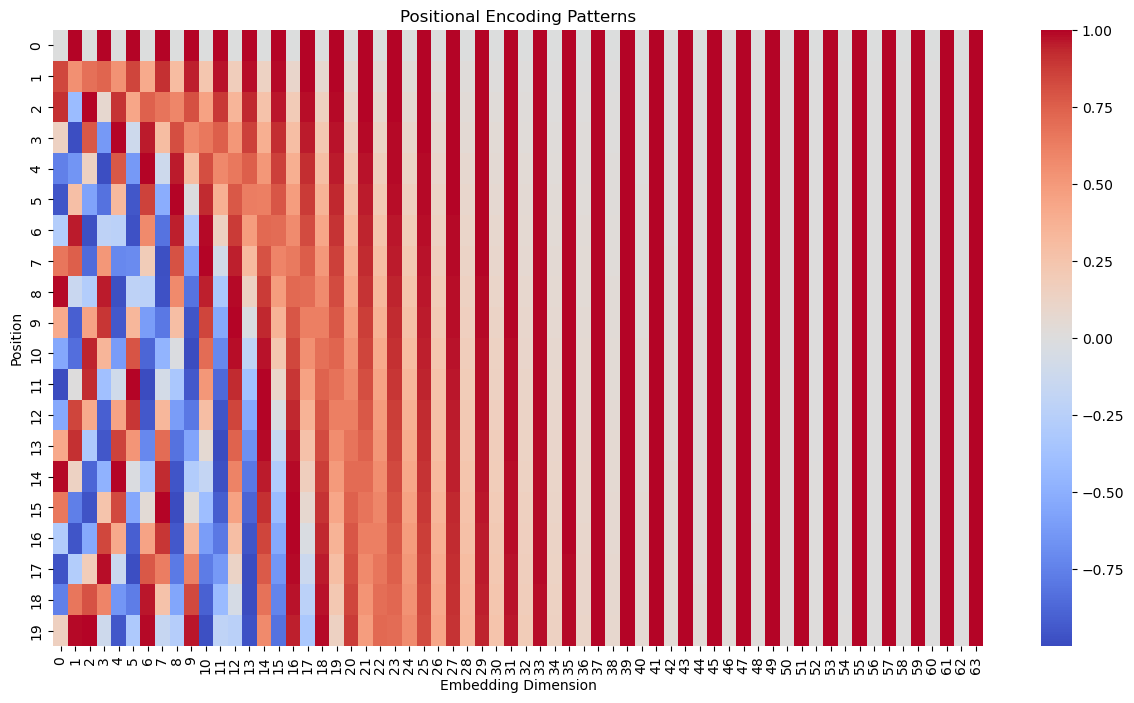

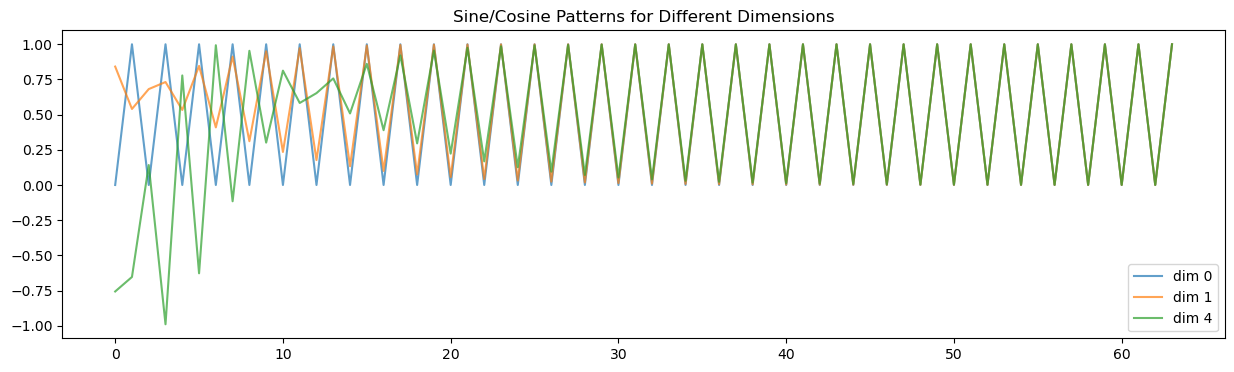


Token Embedding Space:


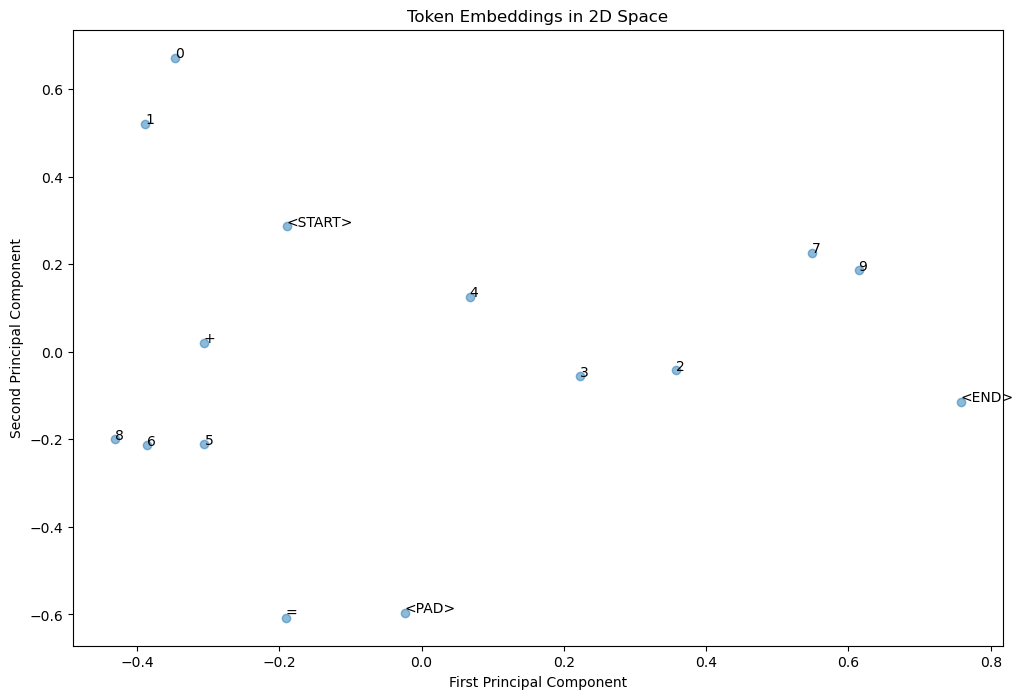


Step-by-Step Computation:
Step 1: Embedding and Positional Encoding


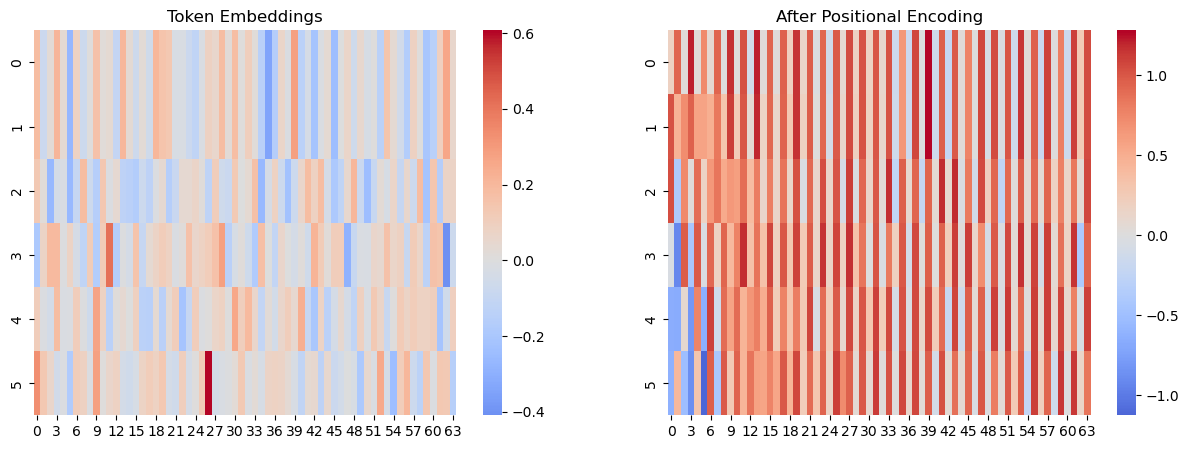


Step 2: Self-Attention Computation


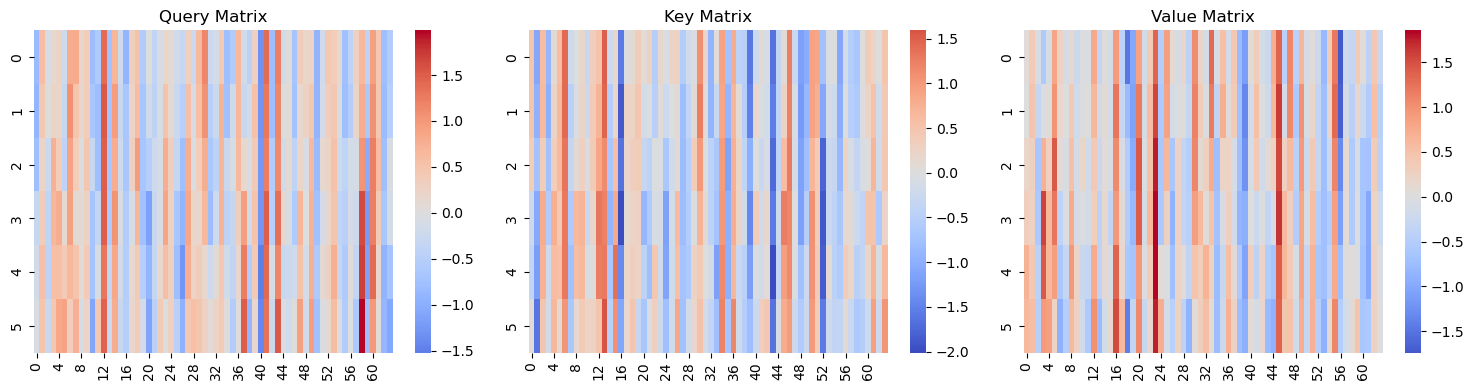


Attention Pattern Interpretations:


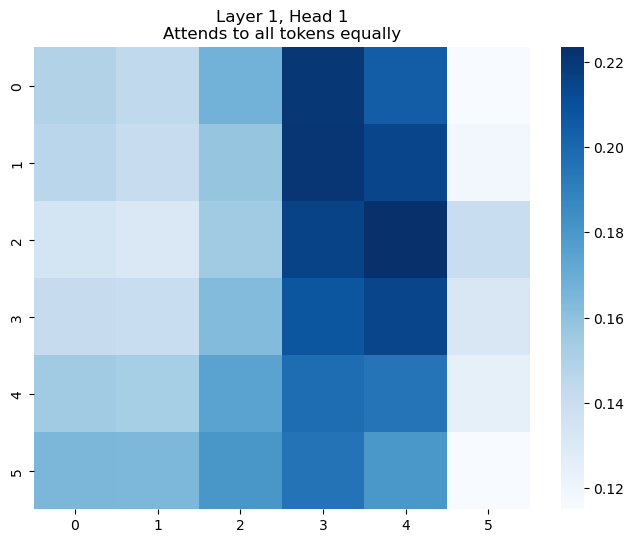

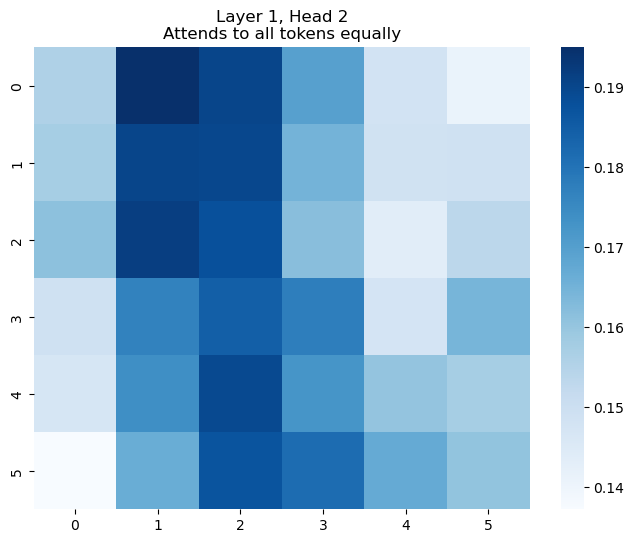

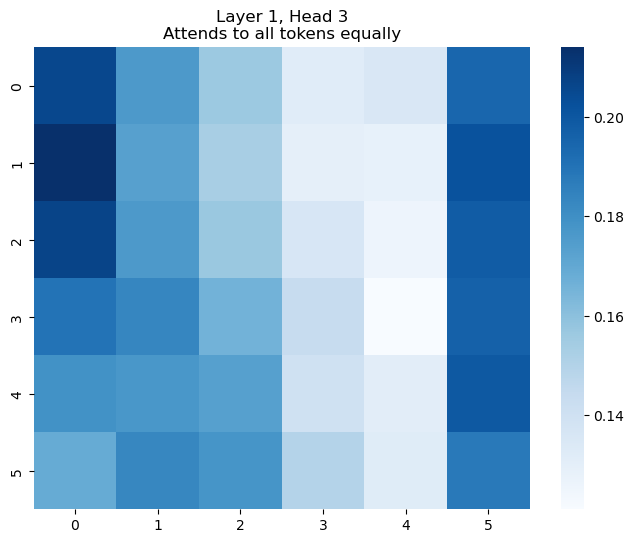

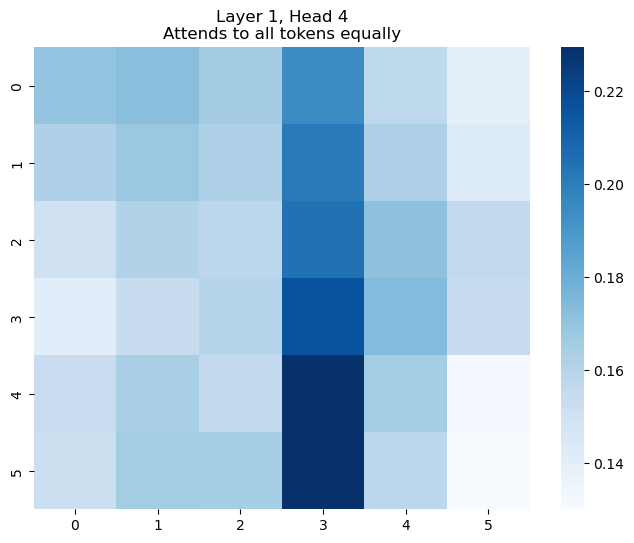

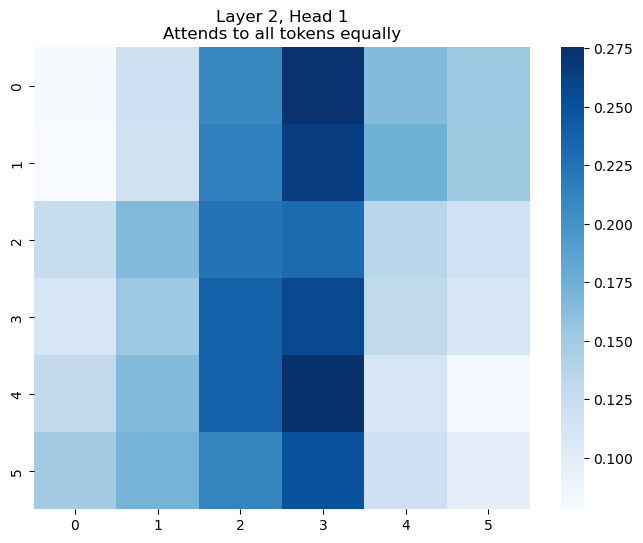

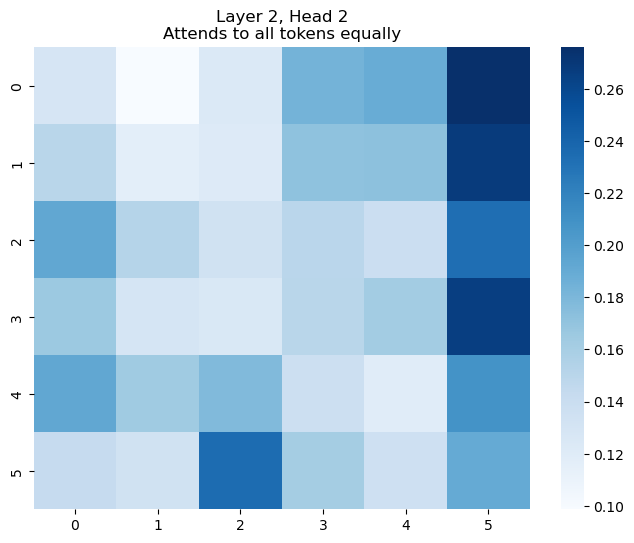

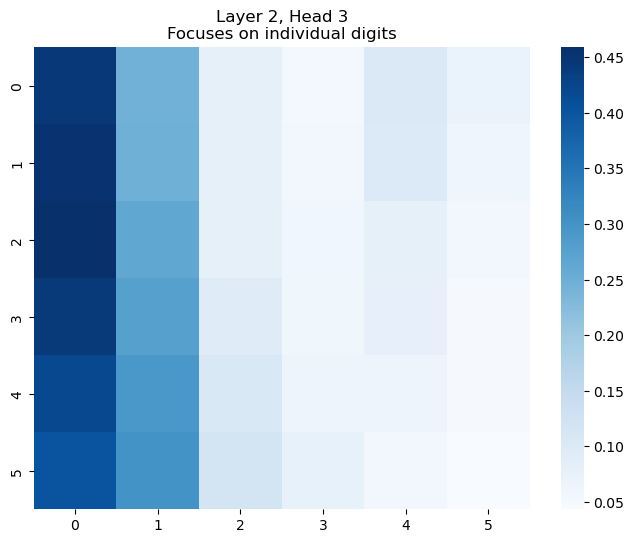

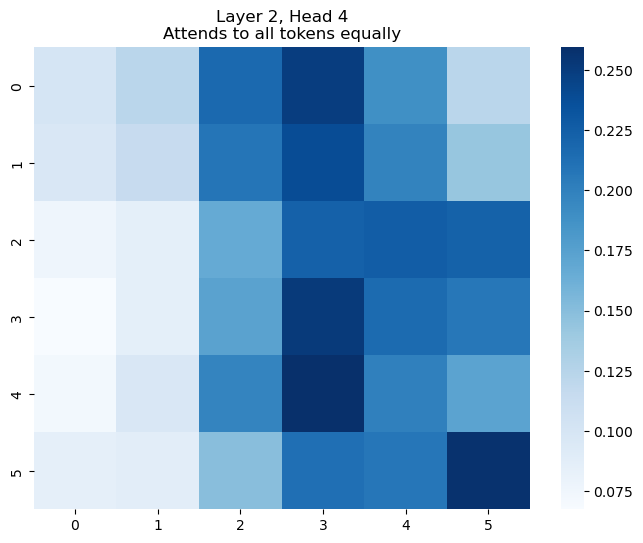


Enhanced Attention Visualization:


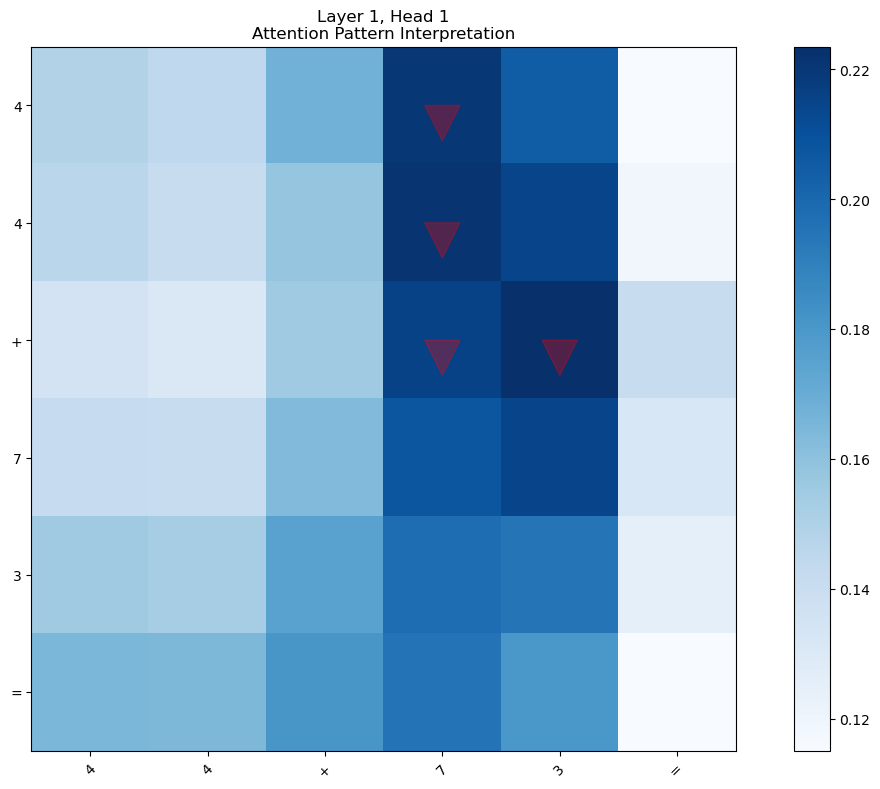


Token Predictions:


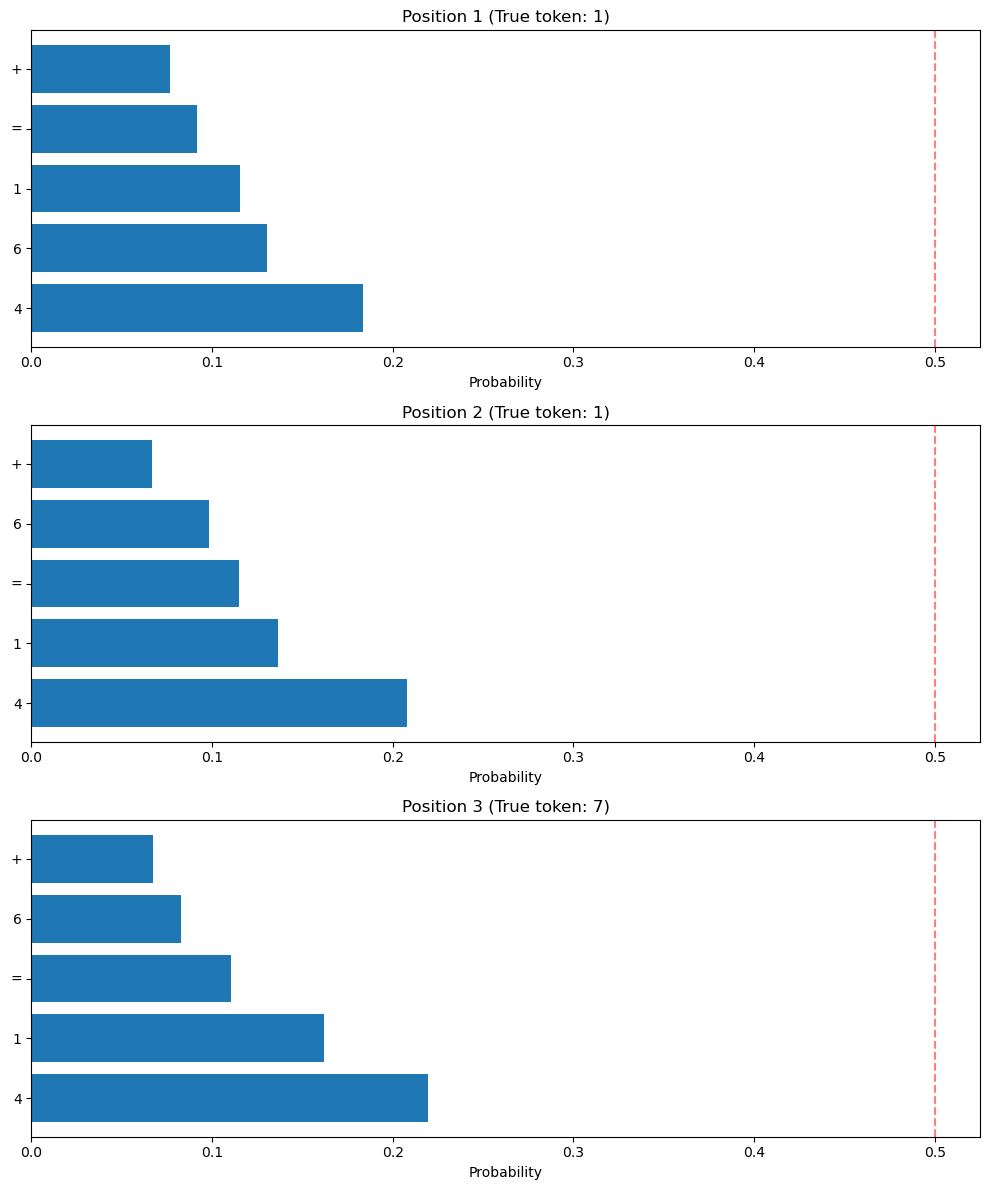

In [24]:
def plot_positional_encoding_patterns(model, max_length=20):
    """Visualize the positional encoding patterns"""
    pos_encoding = model.positional_encoding.pe[0, :max_length, :]
    
    plt.figure(figsize=(15, 8))
    
    sns.heatmap(pos_encoding, cmap='coolwarm', center=0)
    plt.title('Positional Encoding Patterns')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    
    plt.figure(figsize=(15, 4))
    plt.plot(pos_encoding[0, :], label='dim 0', alpha=0.7)
    plt.plot(pos_encoding[1, :], label='dim 1', alpha=0.7)
    plt.plot(pos_encoding[4, :], label='dim 4', alpha=0.7)
    plt.title('Sine/Cosine Patterns for Different Dimensions')
    plt.legend()
    plt.show()

def plot_enhanced_attention(model, src, tgt, idx2token, layer_idx=0, head_idx=0):
    """Plot attention patterns with arrows highlighting important connections"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    attn = model.encoder_layers[layer_idx].self_attn.last_attention_weights[0, head_idx]
    
    im = ax.imshow(attn, cmap='Blues')
    fig.colorbar(im)
    
    src_tokens = [idx2token[idx] for idx in src[0] if idx != 0]
    ax.set_xticks(np.arange(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=45)
    ax.set_yticks(np.arange(len(src_tokens)))
    ax.set_yticklabels(src_tokens, rotation=0)
    
    threshold = np.percentile(attn, 90)  
    for i in range(attn.shape[0]):
        for j in range(attn.shape[1]):
            if attn[i, j] > threshold:
                ax.arrow(j, i, 0, 0, color='red', alpha=0.3, width=0.1,
                        head_width=0.3, head_length=0.3)
    
    ax.set_title(f'Layer {layer_idx+1}, Head {head_idx+1}\nAttention Pattern Interpretation')
    plt.tight_layout()
    plt.show()

def plot_embedding_space(model, token2idx, idx2token):
    """Visualize the embedding space using PCA"""
    embeddings = model.src_embed
    tokens = list(token2idx.keys())
    
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
    
    for i, token in enumerate(tokens):
        plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
    
    plt.title('Token Embeddings in 2D Space')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

def visualize_step_by_step(model, src, tgt):
    """Show step-by-step computation through the transformer"""
    batch_size = src.shape[0]
    
    print("Step 1: Embedding and Positional Encoding")
    src_embedded = model.embed_tokens(src, model.src_embed)
    src_pos_encoded = model.positional_encoding.forward(src_embedded)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(src_embedded[0], cmap='coolwarm', center=0)
    plt.title('Token Embeddings')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(src_pos_encoded[0], cmap='coolwarm', center=0)
    plt.title('After Positional Encoding')
    plt.show()
    
    print("\nStep 2: Self-Attention Computation")
    layer = model.encoder_layers[0]
    Q = np.matmul(src_pos_encoded, layer.self_attn.W_q)
    K = np.matmul(src_pos_encoded, layer.self_attn.W_k)
    V = np.matmul(src_pos_encoded, layer.self_attn.W_v)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, (matrix, title) in enumerate(zip([Q, K, V], ['Query', 'Key', 'Value'])):
        sns.heatmap(matrix[0], ax=axes[i], cmap='coolwarm', center=0)
        axes[i].set_title(f'{title} Matrix')
    plt.tight_layout()
    plt.show()

def plot_attention_interpretation(model, src, idx2token):
    """Interpret what different attention heads learn"""
    interpretations = {
        'digit_attention': 'Focuses on individual digits',
        'operator_attention': 'Focuses on mathematical operators',
        'position_attention': 'Focuses on relative positions',
        'global_attention': 'Attends to all tokens equally'
    }
    
    for layer_idx, layer in enumerate(model.encoder_layers):
        for head_idx in range(layer.self_attn.num_heads):
            attn = layer.self_attn.last_attention_weights[0, head_idx]
            
            operator_focus = np.mean(attn[:, 2])  
            digit_focus = np.mean(attn[:, [0,1,3,4]])  
            
            if operator_focus > 0.5:
                head_type = 'operator_attention'
            elif np.std(attn) < 0.1:
                head_type = 'global_attention'
            elif np.max(attn) - np.min(attn) > 0.5:
                head_type = 'position_attention'
            else:
                head_type = 'digit_attention'
                
            plt.figure(figsize=(8, 6))
            sns.heatmap(attn, cmap='Blues')
            plt.title(f'Layer {layer_idx+1}, Head {head_idx+1}\n{interpretations[head_type]}')
            plt.show()

def plot_token_predictions(output_logits, target_tokens, idx2token):
    """Visualize token prediction probabilities"""
    probs = softmax(output_logits[0], axis=-1)
    
    target_tokens = [idx2token[idx] for idx in target_tokens[0] if idx not in [0, 1, 2]]
    
    fig, axes = plt.subplots(len(target_tokens), 1, figsize=(10, 4*len(target_tokens)))
    if len(target_tokens) == 1:
        axes = [axes]
    elif not isinstance(axes, np.ndarray):
        axes = [axes]
    
    for pos, (ax, true_token) in enumerate(zip(axes, target_tokens)):
        pos_probs = probs[pos]
        top_k = 5
        top_indices = np.argsort(pos_probs)[-top_k:][::-1]
        
        tokens = [idx2token[idx] for idx in top_indices]
        values = pos_probs[top_indices]
        
        ax.barh(range(len(tokens)), values)
        ax.set_yticks(range(len(tokens)))
        ax.set_yticklabels(tokens)
        ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
        ax.set_title(f'Position {pos+1} (True token: {true_token})')
        ax.set_xlabel('Probability')
    
    plt.tight_layout()
    plt.show()

def create_padding_mask(seq):
    mask = (seq != 0)[:, np.newaxis, np.newaxis, :]
    return mask

def create_look_ahead_mask(size):
    mask = np.triu(np.ones((size, size)), k=1)
    return (1 - mask)[np.newaxis, np.newaxis, :, :]

def softmax(x, axis=-1):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def main():
    token2idx, idx2token = create_vocabulary()
    src_data, tgt_data = create_dataset(num_examples=5)
    
    vocab_size = len(token2idx)
    d_model = 64
    num_heads = 4
    num_layers = 2
    d_ff = 128
    
    model = TransformerWithVisualization(
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff
    )
    
    src = src_data[0:1]
    tgt = tgt_data[0:1]
    
    print("\nProcessing example:")
    print("Input sequence:", " ".join([idx2token[idx] for idx in src[0] if idx != 0]))
    print("Target sequence:", " ".join([idx2token[idx] for idx in tgt[0] if idx != 0]))
    
    print("\nPositional Encoding Patterns:")
    plot_positional_encoding_patterns(model)
    
    print("\nToken Embedding Space:")
    plot_embedding_space(model, token2idx, idx2token)
    
    print("\nStep-by-Step Computation:")
    visualize_step_by_step(model, src, tgt)
    
    src_mask = create_padding_mask(src)
    tgt_mask = create_look_ahead_mask(tgt.shape[1])
    output = model.forward(src, tgt, src_mask, tgt_mask)
    
    print("\nAttention Pattern Interpretations:")
    plot_attention_interpretation(model, src, idx2token)
    
    print("\nEnhanced Attention Visualization:")
    plot_enhanced_attention(model, src, tgt, idx2token)
    
    print("\nToken Predictions:")
    plot_token_predictions(output, tgt, idx2token)

if __name__ == "__main__":
    main()

## Understanding the Results

The visualizations show us how the transformer processes our arithmetic problems:

1. **Positional Encodings**: The sine/cosine patterns provide unique position information that helps the model understand token order.

2. **Token Embeddings**: Similar tokens (like digits) tend to cluster together in the embedding space.

3. **Attention Patterns**: Different heads specialize in different aspects:
   - Some focus on digit positions
   - Others attend to operators
   - Some develop position-based patterns

4. **Predictions**: The model learns to generate correct digits for the sum, showing it has learned basic arithmetic operations.